In [ ]:
!pip install opencv-python tensorflow keras scikit-learn matplotlib seaborn numpy pandas grad-cam torch torchvision

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, LSTM, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.convnext import ConvNeXtTiny
import torch
import torch.nn as nn
from torchvision import models
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import timm
import kagglehub
import warnings

In [ ]:
def load_kaggle_ff_dataset():
    try:
        path = kagglehub.dataset_download("xdxd003/ff-c23")
        dataset_path = os.path.join(path, "FaceForensics++_C23")

        if os.path.exists(dataset_path):
            return dataset_path
        else:
            if os.path.exists(path):
                print(f"Using path: {path}")
                return path
            else:
                print("Dataset not found!")
                return None
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return None

# Load the dataset
dataset_path = load_kaggle_ff_dataset()

In [ ]:
real_videos_path = os.path.join(dataset_path, "original")

fake_video_folders = [
    "DeepFakeDetection",
    "Deepfakes",
    "Face2Face",
    "FaceShifter",
    "FaceSwap",
    "NeuralTextures"
]

print("Dataset paths configured:")
print(f"Real videos: {real_videos_path}")
print("Fake video folders:", fake_video_folders)

Dataset paths configured:
Real videos: /kaggle/input/ff-c23/FaceForensics++_C23/original
Fake video folders: ['DeepFakeDetection', 'Deepfakes', 'Face2Face', 'FaceShifter', 'FaceSwap', 'NeuralTextures']


In [ ]:
def get_dataset_info():
    print("Collecting dataset information...")

    # Count real videos
    real_videos = []
    if os.path.exists(real_videos_path):
        for file in os.listdir(real_videos_path):
            if file.endswith(('.mp4', '.avi', '.mov')):
                real_videos.append(os.path.join(real_videos_path, file))

    print(f"Found {len(real_videos)} real videos")

    # Count fake videos
    fake_videos = []
    for folder in fake_video_folders:
        folder_path = os.path.join(dataset_path, folder)
        if os.path.exists(folder_path):
            folder_videos = []
            for file in os.listdir(folder_path):
                if file.endswith(('.mp4', '.avi', '.mov')):
                    folder_videos.append(os.path.join(folder_path, file))
            print(f"Found {len(folder_videos)} {folder} videos")
            fake_videos.extend(folder_videos)

    print(f"Total fake videos: {len(fake_videos)}")
    print(f"Total videos: {len(real_videos) + len(fake_videos)}")

    return real_videos, fake_videos

# Get dataset information
real_video_list, fake_video_list = get_dataset_info()

Found 1000 real videos
Found 1000 DeepFakeDetection videos
Found 1000 Deepfakes videos
Found 1000 Face2Face videos
Found 1000 FaceShifter videos
Found 1000 FaceSwap videos
Found 1000 NeuralTextures videos
Total fake videos: 6000
Total videos: 7000


In [ ]:
def extract_frames_from_video(video_path, max_frames=10, target_size=(224, 224)):
    frames = []
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"Error: Could not open video {video_path}")
        return frames

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate step to get evenly distributed frames
    if total_frames > max_frames:
        step = total_frames // max_frames
    else:
        step = 1

    frame_count = 0
    extracted_count = 0

    while cap.isOpened() and extracted_count < max_frames:
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count % step == 0:
            # Resize frame
            frame = cv2.resize(frame, target_size)
            # Convert BGR to RGB
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            # Normalize pixel values
            frame = frame.astype(np.float32) / 255.0
            frames.append(frame)
            extracted_count += 1

        frame_count += 1

    cap.release()
    return frames

# Test the function with one video
print("Testing frame extraction...")
if real_video_list:
    test_frames = extract_frames_from_video(real_video_list[0], max_frames=5)
    print(f"Extracted {len(test_frames)} frames")
    if test_frames:
        print(f"Frame shape: {test_frames[0].shape}")

Testing frame extraction...
Extracted 5 frames
Frame shape: (224, 224, 3)


In [ ]:
# Extract visual features from a single frame
# Features extracted:
#   1. Color histogram features
#   2. Texture features (using Laplacian variance)
#   3. Edge features
#   4. Brightness and contrast statistics

def extract_visual_features(frame):
    features = []

    # Convert to different color spaces for analysis
    gray = cv2.cvtColor((frame * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    hsv = cv2.cvtColor((frame * 255).astype(np.uint8), cv2.COLOR_RGB2HSV)

    # 1. Color histogram features (RGB)
    for i in range(3):  # R, G, B channels
        hist = cv2.calcHist([(frame * 255).astype(np.uint8)], [i], None, [32], [0, 256])
        features.extend(hist.flatten())

    # 2. HSV histogram features
    for i in range(3):  # H, S, V channels
        hist = cv2.calcHist([hsv], [i], None, [32], [0, 256])
        features.extend(hist.flatten())

    # 3. Texture features - Laplacian variance (measure of blurriness)
    laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()
    features.append(laplacian_var)

    # 4. Edge features - Canny edge density
    edges = cv2.Canny(gray, 50, 150)
    edge_density = np.sum(edges > 0) / (edges.shape[0] * edges.shape[1])
    features.append(edge_density)

    # 5. Brightness and contrast statistics
    features.append(np.mean(gray))  # Average brightness
    features.append(np.std(gray))   # Contrast (standard deviation)
    features.append(np.min(gray))   # Minimum brightness
    features.append(np.max(gray))   # Maximum brightness

    # 6. Gradient magnitude statistics
    grad_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)
    features.append(np.mean(gradient_magnitude))
    features.append(np.std(gradient_magnitude))

    return np.array(features)

# Extract temporal features from sequence of frames
def extract_temporal_features(frames):
    if len(frames) < 2:
        return np.array([0, 0, 0])  # Return zeros if not enough frames

    temporal_features = []

    # Frame-to-frame differences
    frame_diffs = []
    for i in range(1, len(frames)):
        diff = np.mean(np.abs(frames[i] - frames[i-1]))
        frame_diffs.append(diff)

    temporal_features.append(np.mean(frame_diffs))  # Average frame difference
    temporal_features.append(np.std(frame_diffs))   # Frame difference variance
    temporal_features.append(np.max(frame_diffs))   # Maximum frame difference

    return np.array(temporal_features)

# Test feature extraction
print("Testing feature extraction...")
if real_video_list:
    test_frames = extract_frames_from_video(real_video_list[0], max_frames=3)
    if test_frames:
        visual_features = extract_visual_features(test_frames[0])
        temporal_features = extract_temporal_features(test_frames)
        print(f"Visual features shape: {visual_features.shape}")
        print(f"Temporal features shape: {temporal_features.shape}")

Testing feature extraction...
Visual features shape: (200,)
Temporal features shape: (3,)


In [ ]:
# Load and process the entire dataset
def load_dataset(real_videos, fake_videos, max_videos_per_class=500, max_frames=10):
    print("Loading dataset...")

    X_visual = []  # Visual features
    X_temporal = []  # Temporal features
    X_raw = []  # Raw frame sequences for deep learning
    y = []  # Labels

    # Process real videos
    print("Processing real videos...")
    count = 0
    for video_path in real_videos[:max_videos_per_class]:
        try:
            frames = extract_frames_from_video(video_path, max_frames)
            if len(frames) > 0:
                # Extract features for each frame and average them
                frame_visual_features = []
                for frame in frames:
                    features = extract_visual_features(frame)
                    frame_visual_features.append(features)

                # Average visual features across frames
                avg_visual_features = np.mean(frame_visual_features, axis=0)

                # Extract temporal features
                temp_features = extract_temporal_features(frames)

                # Pad or truncate frames to fixed length
                if len(frames) < max_frames:
                    # Pad with last frame
                    while len(frames) < max_frames:
                        frames.append(frames[-1])
                else:
                    frames = frames[:max_frames]

                X_visual.append(avg_visual_features)
                X_temporal.append(temp_features)
                X_raw.append(np.array(frames))
                y.append(0)  # 0 for real

                count += 1
                if count % 50 == 0:
                    print(f"Processed {count} real videos")

        except Exception as e:
            print(f"Error processing {video_path}: {e}")
            continue

    print(f"Processed {count} real videos successfully")

    # Process fake videos
    print("Processing fake videos...")
    count = 0
    for video_path in fake_videos[:max_videos_per_class]:
        try:
            frames = extract_frames_from_video(video_path, max_frames)
            if len(frames) > 0:
                # Extract features for each frame and average them
                frame_visual_features = []
                for frame in frames:
                    features = extract_visual_features(frame)
                    frame_visual_features.append(features)

                # Average visual features across frames
                avg_visual_features = np.mean(frame_visual_features, axis=0)

                # Extract temporal features
                temp_features = extract_temporal_features(frames)

                # Pad or truncate frames to fixed length
                if len(frames) < max_frames:
                    while len(frames) < max_frames:
                        frames.append(frames[-1])
                else:
                    frames = frames[:max_frames]

                X_visual.append(avg_visual_features)
                X_temporal.append(temp_features)
                X_raw.append(np.array(frames))
                y.append(1)  # 1 for fake

                count += 1
                if count % 50 == 0:
                    print(f"Processed {count} fake videos")

        except Exception as e:
            print(f"Error processing {video_path}: {e}")
            continue

    print(f"Processed {count} fake videos successfully")

    return np.array(X_visual), np.array(X_temporal), np.array(X_raw), np.array(y)

# Load the dataset (start with smaller number for testing)
X_visual, X_temporal, X_raw, y = load_dataset(real_video_list, fake_video_list,
                                            max_videos_per_class=100, max_frames=10)

print(f"Dataset loaded successfully!")
print(f"Visual features shape: {X_visual.shape}")
print(f"Temporal features shape: {X_temporal.shape}")
print(f"Raw frames shape: {X_raw.shape}")
print(f"Labels shape: {y.shape}")
print(f"Real videos: {np.sum(y == 0)}, Fake videos: {np.sum(y == 1)}")

Loading dataset...
Processing real videos...
Processed 50 real videos
Processed 100 real videos
Processed 100 real videos successfully
Processing fake videos...
Processed 50 fake videos
Processed 100 fake videos
Processed 100 fake videos successfully
Dataset loaded successfully!
Visual features shape: (200, 200)
Temporal features shape: (200, 3)
Raw frames shape: (200, 10, 224, 224, 3)
Labels shape: (200,)
Real videos: 100, Fake videos: 100


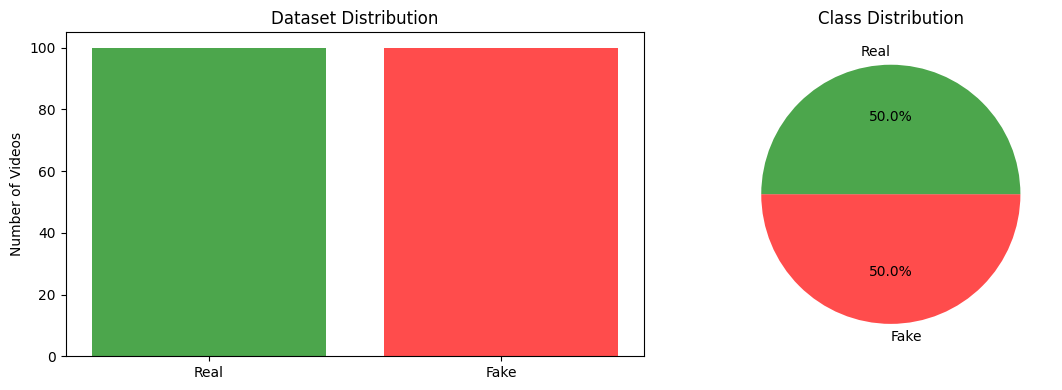

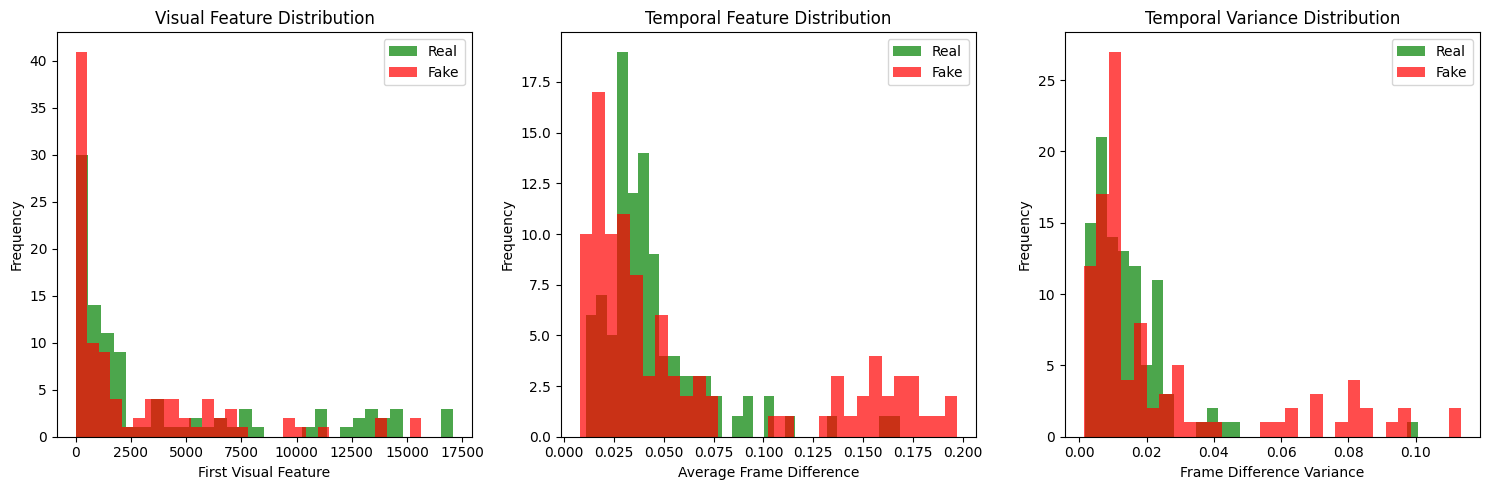

In [ ]:
# Plot dataset distribution
def plot_dataset_summary(y):
    plt.figure(figsize=(12, 4))

    # Subplot 1: Class distribution
    plt.subplot(1, 2, 1)
    labels = ['Real', 'Fake']
    counts = [np.sum(y == 0), np.sum(y == 1)]
    plt.bar(labels, counts, color=['green', 'red'], alpha=0.7)
    plt.title('Dataset Distribution')
    plt.ylabel('Number of Videos')

    # Subplot 2: Pie chart
    plt.subplot(1, 2, 2)
    patches, texts, autotexts = plt.pie(counts, labels=labels, colors=['green', 'red'], autopct='%1.1f%%')
    # Set alpha for each wedge
    for patch in patches:
        patch.set_alpha(0.7)
    plt.title('Class Distribution')

    plt.tight_layout()
    plt.show()

# Plot some feature distributions
def plot_feature_distributions(X_visual, X_temporal, y):
    plt.figure(figsize=(15, 5))

    # Plot some visual features
    plt.subplot(1, 3, 1)
    plt.hist(X_visual[y==0, 0], alpha=0.7, label='Real', bins=30, color='green')
    plt.hist(X_visual[y==1, 0], alpha=0.7, label='Fake', bins=30, color='red')
    plt.xlabel('First Visual Feature')
    plt.ylabel('Frequency')
    plt.title('Visual Feature Distribution')
    plt.legend()

    # Plot temporal features
    plt.subplot(1, 3, 2)
    plt.hist(X_temporal[y==0, 0], alpha=0.7, label='Real', bins=30, color='green')
    plt.hist(X_temporal[y==1, 0], alpha=0.7, label='Fake', bins=30, color='red')
    plt.xlabel('Average Frame Difference')
    plt.ylabel('Frequency')
    plt.title('Temporal Feature Distribution')
    plt.legend()

    # Plot another temporal feature
    plt.subplot(1, 3, 3)
    plt.hist(X_temporal[y==0, 1], alpha=0.7, label='Real', bins=30, color='green')
    plt.hist(X_temporal[y==1, 1], alpha=0.7, label='Fake', bins=30, color='red')
    plt.xlabel('Frame Difference Variance')
    plt.ylabel('Frequency')
    plt.title('Temporal Variance Distribution')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Create visualizations
plot_dataset_summary(y)
plot_feature_distributions(X_visual, X_temporal, y)

In [ ]:
# Combine visual and temporal features
X_combined = np.concatenate([X_visual, X_temporal], axis=1)

print(f"Combined features shape: {X_combined.shape}")

# Split the data
X_train_combined, X_test_combined, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42, stratify=y
)

X_train_raw, X_test_raw, _, _ = train_test_split(
    X_raw, y, test_size=0.2, random_state=42, stratify=y
)

print("Data split successfully:")
print(f"Training set: {X_train_combined.shape[0]} samples")
print(f"Test set: {X_test_combined.shape[0]} samples")
print(f"Training labels - Real: {np.sum(y_train == 0)}, Fake: {np.sum(y_train == 1)}")
print(f"Test labels - Real: {np.sum(y_test == 0)}, Fake: {np.sum(y_test == 1)}")

Combined features shape: (200, 203)
Data split successfully:
Training set: 160 samples
Test set: 40 samples
Training labels - Real: 80, Fake: 80
Test labels - Real: 20, Fake: 20


Training traditional ML models...

Training Random Forest...
Random Forest Accuracy: 0.9250

Classification Report:
              precision    recall  f1-score   support

        Real       0.95      0.90      0.92        20
        Fake       0.90      0.95      0.93        20

    accuracy                           0.93        40
   macro avg       0.93      0.93      0.92        40
weighted avg       0.93      0.93      0.92        40


Training SVM...
SVM Accuracy: 0.8750

Classification Report:
              precision    recall  f1-score   support

        Real       0.89      0.85      0.87        20
        Fake       0.86      0.90      0.88        20

    accuracy                           0.88        40
   macro avg       0.88      0.88      0.87        40
weighted avg       0.88      0.88      0.87        40


Training Logistic Regression...
Logistic Regression Accuracy: 0.8750

Classification Report:
              precision    recall  f1-score   support

        Real       

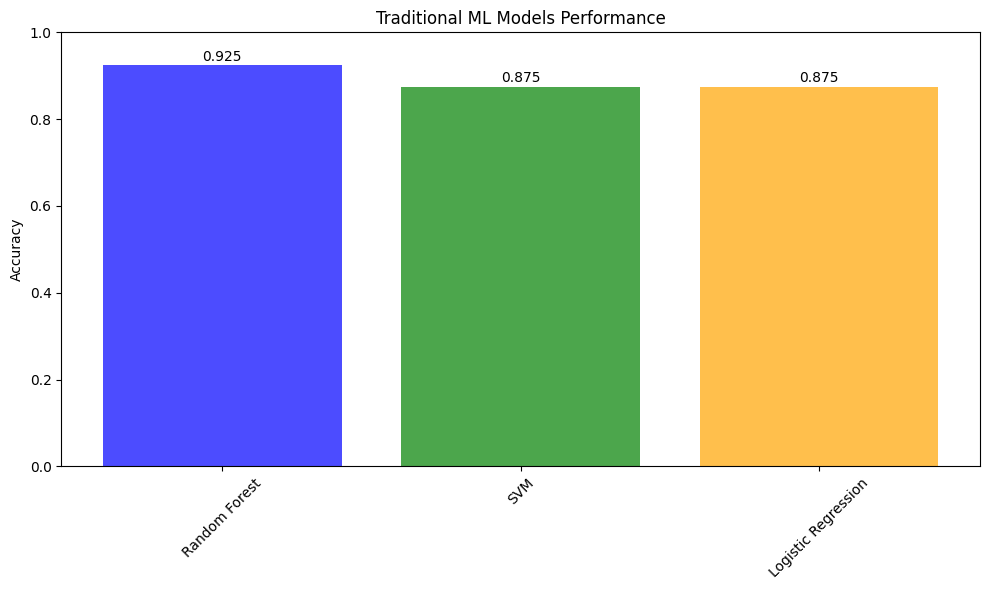

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_combined)
X_test_scaled = scaler.transform(X_test_combined)

# Train different models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='rbf', random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42)
}

results = {}

print("Training traditional ML models...")
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = model.predict(X_test_scaled)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy

    print(f"{name} Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Real', 'Fake']))

# Plot results
plt.figure(figsize=(10, 6))
models_names = list(results.keys())
accuracies = list(results.values())

plt.bar(models_names, accuracies, color=['blue', 'green', 'orange'], alpha=0.7)
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Traditional ML Models Performance')
plt.xticks(rotation=45)

# Add accuracy values on bars
for i, accuracy in enumerate(accuracies):
    plt.text(i, accuracy + 0.01, f'{accuracy:.3f}', ha='center')

plt.tight_layout()
plt.show()

In [ ]:
# Create a CNN model for single frame analysis
def create_cnn_model(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    return model

# Prepare data for CNN (we'll use the middle frame from each video)
X_train_cnn = X_train_raw[:, 5, :, :, :]  # Use middle frame (index 5 out of 10)
X_test_cnn = X_test_raw[:, 5, :, :, :]

print(f"CNN training data shape: {X_train_cnn.shape}")
print(f"CNN test data shape: {X_test_cnn.shape}")

# Create and compile the model
cnn_model = create_cnn_model(X_train_cnn.shape[1:])
cnn_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("CNN Model Summary:")
cnn_model.summary()

CNN training data shape: (160, 224, 224, 3)
CNN test data shape: (40, 224, 224, 3)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


CNN Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,810,113 (37.42 MB)

 Trainable params: 9,810,113 (37.42 MB)

 Non-trainable params: 0 (0.00 B)

Training CNN model...
Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 939ms/step - accuracy: 0.4567 - loss: 0.7969 - val_accuracy: 0.5000 - val_loss: 0.6897
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.5388 - loss: 0.6889 - val_accuracy: 0.5000 - val_loss: 0.6691
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 227ms/step - accuracy: 0.5984 - loss: 0.6625 - val_accuracy: 0.7500 - val_loss: 0.5929
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 227ms/step - accuracy: 0.7366 - loss: 0.5595 - val_accuracy: 0.8500 - val_loss: 0.4421
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.7992 - loss: 0.4380 - val_accuracy: 0.7750 - val_loss: 0.4152
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.8848 - loss: 0.3169 - val_accuracy: 0.7750 - val_loss: 0.4489
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9256 - loss: 0.1884 - val_accuracy: 0.8000 - val_loss: 0.6680
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 453ms/step - accuracy: 0.9015 - loss: 0.2366 - val_accuracy:

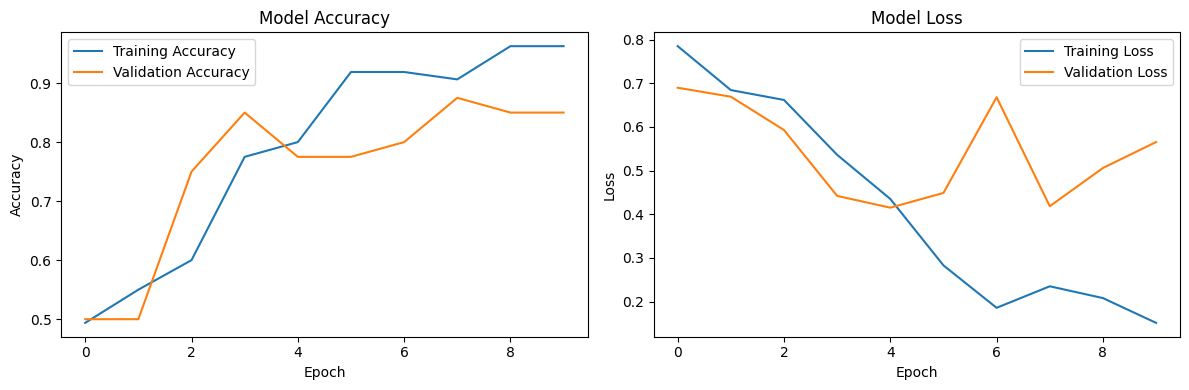

In [ ]:
# Set up callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    'best_cnn_model.keras',
    monitor='val_accuracy',
    save_best_only=True
)

# Train the model
print("Training CNN model...")
history = cnn_model.fit(
    X_train_cnn, y_train,
    batch_size=32,
    epochs=20,
    validation_data=(X_test_cnn, y_test),
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
def create_convnext_lstm_model(input_shape):
    convnext_base = ConvNeXtTiny(weights='imagenet', include_top=False)
    convnext_base.trainable = False  # Optional: freeze weights

    model = Sequential([
        TimeDistributed(convnext_base, input_shape=input_shape),
        TimeDistributed(Flatten()),
        LSTM(128, return_sequences=True),
        LSTM(64),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    return model

# Usage as before

# Create and compile the ConvNeXt-LSTM model
# Ensure X_train_raw.shape[1:] is (timesteps, height, width, channels)
cnn_lstm_model = create_convnext_lstm_model(X_train_raw.shape[1:])
cnn_lstm_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("ConvNeXt-LSTM Model Summary:")
cnn_lstm_model.summary()

ConvNeXt-LSTM Model Summary:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_4              │ (None, 10, 7, 7, 768)  │    27,820,128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 10, 37632)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 10, 128)        │    19,333,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,252,833 (180.26 MB)

 Trainable params: 19,432,705 (74.13 MB)

 Non-trainable params: 27,820,128 (106.13 MB)

Training CNN-LSTM model...
Epoch 1/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 146s 3s/step - accuracy: 0.4827 - loss: 0.7151 - val_accuracy: 0.5250 - val_loss: 0.6861
Epoch 2/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.5956 - loss: 0.6714 - val_accuracy: 0.7750 - val_loss: 0.6616
Epoch 3/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.6983 - loss: 0.6378 - val_accuracy: 0.8250 - val_loss: 0.6146
Epoch 4/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.8799 - loss: 0.5660 - val_accuracy: 0.8250 - val_loss: 0.5623
Epoch 5/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9388 - loss: 0.4690 - val_accuracy: 0.8750 - val_loss: 0.4645
Epoch 6/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9402 - loss: 0.4114 - val_accuracy: 0.8750 - val_loss: 0.3779
Epoch 7/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9921 - loss: 0.2548 - val_accuracy: 0.8000 - val_loss: 0.3961
Epoch 8/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9936 - loss: 0.1890 - val_

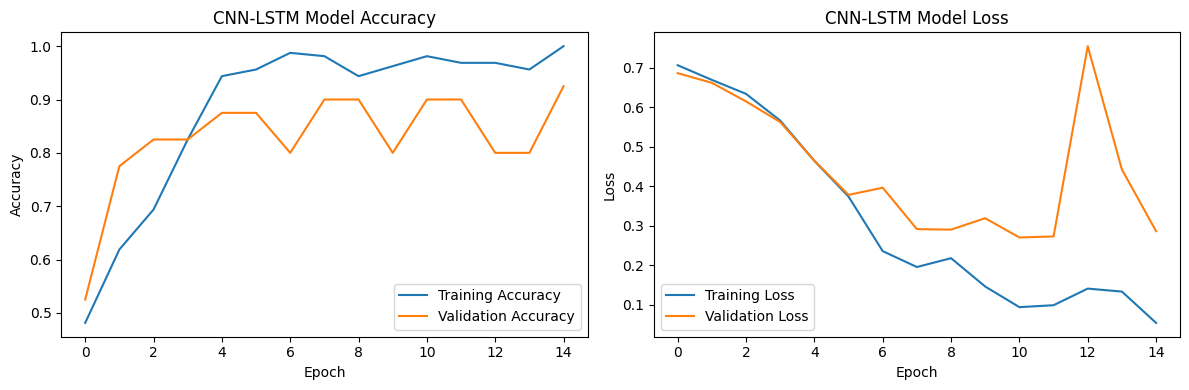

In [ ]:
# Train the CNN-LSTM model
print("Training CNN-LSTM model...")
history_lstm = cnn_lstm_model.fit(
    X_train_raw, y_train,
    batch_size=8,
    epochs=15,
    validation_data=(X_test_raw, y_test),
    callbacks=[early_stopping],
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['accuracy'], label='Training Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN-LSTM Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['loss'], label='Training Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('CNN-LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Traditional ML Models:
Random Forest: 0.9250
SVM: 0.8750
Logistic Regression: 0.8750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step 

CNN Model: 0.7750
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 777ms/step
CNN-LSTM Model: 0.9000


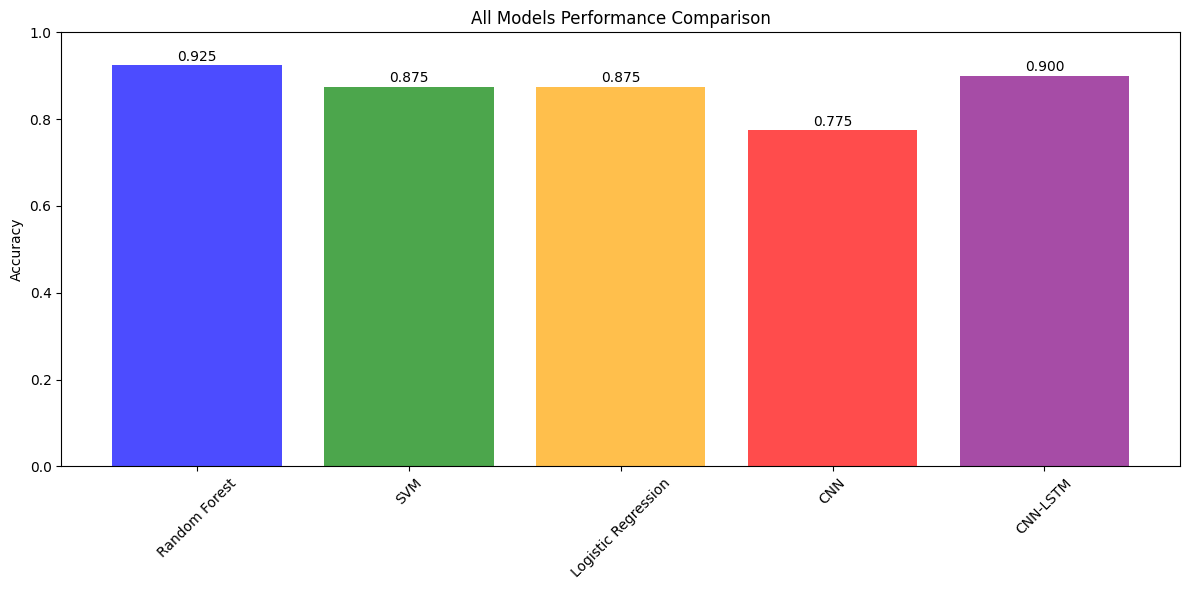

In [ ]:
# Evaluate all models

# Traditional ML models (already evaluated above)
print("Traditional ML Models:")
for name, accuracy in results.items():
    print(f"{name}: {accuracy:.4f}")

# CNN model
cnn_predictions = cnn_model.predict(X_test_cnn)
cnn_predictions_binary = (cnn_predictions > 0.5).astype(int).flatten()
cnn_accuracy = accuracy_score(y_test, cnn_predictions_binary)
print(f"\nCNN Model: {cnn_accuracy:.4f}")

# CNN-LSTM model
lstm_predictions = cnn_lstm_model.predict(X_test_raw)
lstm_predictions_binary = (lstm_predictions > 0.5).astype(int).flatten()
lstm_accuracy = accuracy_score(y_test, lstm_predictions_binary)
print(f"CNN-LSTM Model: {lstm_accuracy:.4f}")

# Create comprehensive comparison
all_results = results.copy()
all_results['CNN'] = cnn_accuracy
all_results['CNN-LSTM'] = lstm_accuracy

# Plot comparison
plt.figure(figsize=(12, 6))
models_names = list(all_results.keys())
accuracies = list(all_results.values())

bars = plt.bar(models_names, accuracies,
               color=['blue', 'green', 'orange', 'red', 'purple'], alpha=0.7)
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('All Models Performance Comparison')
plt.xticks(rotation=45)

# Add accuracy values on bars
for i, accuracy in enumerate(accuracies):
    plt.text(i, accuracy + 0.01, f'{accuracy:.3f}', ha='center')

plt.tight_layout()
plt.show()

# Best model
best_model = cnn_lstm_model

In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    print("Google Drive mounted successfully.")
except ImportError:
    print("Not running in Google Colab. Skipping Google Drive mounting.")

# Define the target save path in Google Drive
save_path = '/content/drive/My Drive/deepfake_detection/models'

# Create the directory if it doesn't exist
os.makedirs(save_path, exist_ok=True)
print(f"Ensured save directory exists: {save_path}")

Mounted at /content/drive
Google Drive mounted successfully.
Ensured save directory exists: /content/drive/My Drive/deepfake_detection/models


In [ ]:
# Save the CNN-LSTM model
lstm_model_file = os.path.join(save_path, 'cnn_lstm_model.keras')
cnn_lstm_model.save(lstm_model_file)
print(f"\nSaved CNN-LSTM model to: {lstm_model_file}")

# Save the CNN model
cnn_model_file = os.path.join(save_path, 'cnn_model.keras')
cnn_model.save(cnn_model_file)
print(f"Saved CNN model to: {cnn_model_file}")

print("\nModel saving complete.")


Saved CNN-LSTM model to: /content/drive/My Drive/deepfake_detection/models/cnn_lstm_model.keras
Saved CNN model to: /content/drive/My Drive/deepfake_detection/models/cnn_model.keras

Model saving complete.


In [ ]:
import os
import numpy as np
from tensorflow.keras.models import load_model

model_path = '/content/drive/My Drive/deepfake_detection/models/cnn_lstm_model.keras'

# Load the saved model
try:
    loaded_model = load_model(model_path)
    print("Model loaded successfully!")
    loaded_model.summary()

except Exception as e:
    print(f"An error occurred while loading the model: {e}")

Model loaded successfully!


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_4              │ (None, 10, 7, 7, 768)  │    27,820,128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 10, 37632)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 10, 128)        │    19,333,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 86,118,245 (328.52 MB)

 Trainable params: 19,432,705 (74.13 MB)

 Non-trainable params: 27,820,128 (106.13 MB)

 Optimizer params: 38,865,412 (148.26 MB)

In [ ]:
!pip install tf-keras-vis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 568.5 kB/s eta 0:00:00


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.applications import ConvNeXtTiny
from tensorflow.keras.optimizers import Adam
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import BinaryScore
import matplotlib.pyplot as plt
import cv2

# Define loss function for Grad-CAM
def loss_fn(output):
    return output[0]  # Binary classification output

# Get the last convolutional layer in ConvNeXt
def get_last_conv_layer(model):
    for layer in model.layers[0].layers:  # Access ConvNeXt layers
        if 'conv' in layer.name.lower() and isinstance(layer, tf.keras.layers.Conv2D):
            last_conv_layer = layer
    return last_conv_layer

# Function to generate Grad-CAM heatmap for a single video sample
def generate_gradcam(model, video_path, timestep=0, max_frames=10):
    # Extract and preprocess frames
    frames = extract_frames_from_video(video_path, max_frames)
    input_data = np.expand_dims(frames, axis=0)  # Add batch dimension: (1, max_frames, 224, 224, 3)

    gradcam = GradcamPlusPlus(
        model,
        model_modifier=ReplaceToLinear(),
        clone=False
    )

    # Generate heatmap for the specified timestep
    cam = gradcam(
        score=BinaryScore(True),  # For positive class (e.g., deepfake)
        seed_input=input_data[:, timestep:timestep+1],  # Single timestep
        penultimate_layer=get_last_conv_layer(model),  # Last conv layer
        expand_cam=True,
        normalize_cam=True
    )

    # Denormalize frame for visualization
    frame = input_data[0, timestep]
    frame = frame * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    frame = np.clip(frame, 0, 1)

    return frame, cam

In [ ]:
import os
import tensorflow as tf

# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Define the correct file path
# Use the os.path.join() function for cleaner and safer path handling.
save_path = '/content/drive/My Drive/deepfake_detection/models/'
lstm_model_file = os.path.join(save_path, 'cnn_lstm_model.keras')

# Step 3: Load the model from the verified path
try:
    cnn_lstm_model = tf.keras.models.load_model(lstm_model_file)
    print(f"\nSuccessfully loaded model from: {lstm_model_file}")

    # Now you can proceed with your Grad-CAM implementation
    sample_video = os.path.join(dataset_path, "Deepfakes", "479_706.mp4")
    frame, heatmap = generate_gradcam(cnn_lstm_model, sample_video, timestep=0)
    # Visualize heatmap
    plt.imshow(frame)
    plt.imshow(heatmap[0], cmap='jet', alpha=0.5)  # Overlay heatmap
    plt.colorbar()
    plt.title('Grad-CAM Heatmap')
    plt.show()

except Exception as e:
    print(f"An error occurred: {e}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Successfully loaded model from: /content/drive/My Drive/deepfake_detection/models/cnn_lstm_model.keras
An error occurred: 'Sequential' object has no attribute 'output_names'


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import TimeDistributed, Flatten, LSTM, Dense, Dropout
from tensorflow.keras.applications import ConvNeXtTiny
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Import tf-keras-vis
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.scorecam import Scorecam
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

def visualize_gradcam_video(model, video_frames, class_index=0, layer_name=None):
    """
    Generate GradCAM visualization for video frames

    Args:
        model: Trained ConvNeXt-LSTM model
        video_frames: Array of video frames (timesteps, height, width, channels)
        class_index: Class index for visualization (0 for binary classification)
        layer_name: Specific layer name for GradCAM (optional)
    """

    # Prepare the input (add batch dimension)
    video_input = np.expand_dims(video_frames, axis=0)

    # Create GradCAM object
    # Replace final activation with linear for better gradients
    gradcam = Gradcam(model,
                      model_modifier=ReplaceToLinear(),
                      clone=True)

    # Define score function for your specific output
    def model_score_function(output):
        return output[:, 0] if len(output.shape) > 1 else output

    # Generate GradCAM for each timestep
    gradcam_maps = []

    for timestep in range(video_frames.shape[0]):
        # Extract single frame and add dimensions
        single_frame = np.expand_dims(np.expand_dims(video_frames[timestep], axis=0), axis=0)

        try:
            # Generate GradCAM
            cam = gradcam(model_score_function,
                         single_frame,
                         penultimate_layer=-1)  # Use last convolutional layer

            gradcam_maps.append(cam[0, 0])  # Remove batch and time dimensions

        except Exception as e:
            print(f"Error generating GradCAM for timestep {timestep}: {e}")
            # Use zero array as fallback
            gradcam_maps.append(np.zeros_like(video_frames[timestep][:, :, 0]))

    return np.array(gradcam_maps)

def create_frame_level_model(trained_model, input_shape=(224, 224, 3)):
    """
    Create a model that can process single frames for GradCAM
    This is a workaround for TimeDistributed layers
    """
    # Get the ConvNeXt base model
    convnext_base = trained_model.layers[0].layer  # Get the actual ConvNeXt model

    # Create a simple model for single frame processing with explicit input shape
    frame_model = Sequential([
        convnext_base,
        Flatten()
    ])

    # Build the model with a sample input to define shapes
    dummy_input = tf.zeros((1,) + input_shape)
    _ = frame_model(dummy_input)

    return frame_model

# Add a simpler GradCAM approach specifically for your model
def simple_gradcam_for_video(trained_model, video_frames):
    """
    Simplified GradCAM implementation that works with ConvNeXt-LSTM architecture
    """
    gradcam_maps = []

    # Get the ConvNeXt base model
    convnext_base = trained_model.layers[0].layer

    # Print available layers for debugging
    print("Available ConvNeXt layers:")
    for layer in convnext_base.layers:
        print(f"  - {layer.name}")

    # Find a suitable convolutional layer
    target_layer_name = None
    for layer in reversed(convnext_base.layers):
        if any(keyword in layer.name.lower() for keyword in ['conv', 'stage', 'block']):
            target_layer_name = layer.name
            break

    if target_layer_name is None:
        # Use the layer before the final pooling/classifier layers
        target_layer_name = convnext_base.layers[-3].name

    print(f"Using layer for GradCAM: {target_layer_name}")

    for i, frame in enumerate(video_frames):
        try:
            # Prepare frame
            frame_input = tf.expand_dims(frame, 0)

            # Create GradCAM model using the ConvNeXt base directly
            grad_model = tf.keras.Model(
                convnext_base.inputs,
                [convnext_base.get_layer(target_layer_name).output, convnext_base.output]
            )

            with tf.GradientTape() as tape:
                conv_outputs, predictions = grad_model(frame_input)
                # Use mean of predictions as class score
                class_score = tf.reduce_mean(predictions)

            # Compute gradients
            grads = tape.gradient(class_score, conv_outputs)
            pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

            # Weight the feature maps
            conv_outputs_weighted = conv_outputs[0]
            for j in range(pooled_grads.shape[-1]):
                conv_outputs_weighted = conv_outputs_weighted * tf.expand_dims(tf.expand_dims(pooled_grads[j], 0), 0)

            # Create heatmap
            heatmap = tf.reduce_mean(conv_outputs_weighted, axis=-1)
            heatmap = tf.maximum(heatmap, 0)
            if tf.reduce_max(heatmap) > 0:
                heatmap = heatmap / tf.reduce_max(heatmap)

            # Resize to original frame size
            heatmap_resized = tf.image.resize(
                tf.expand_dims(tf.expand_dims(heatmap, 0), -1),
                [frame.shape[0], frame.shape[1]]
            )
            heatmap_resized = tf.squeeze(heatmap_resized).numpy()

            gradcam_maps.append(heatmap_resized)

        except Exception as e:
            print(f"Error processing frame {i}: {e}")
            gradcam_maps.append(np.zeros((frame.shape[0], frame.shape[1])))

    return np.array(gradcam_maps)

def visualize_gradcam_alternative(trained_model, video_frames):
    """
    Alternative GradCAM approach using frame-level analysis
    """
    # First try the simple approach
    print("Attempting simple GradCAM...")
    result = simple_gradcam_for_video(trained_model, video_frames)

    # If that fails, try tf-keras-vis approach
    if np.all(result == 0):
        print("Simple GradCAM failed, trying tf-keras-vis approach...")
        return gradcam_with_tf_keras_vis(trained_model, video_frames)

    return result

def gradcam_with_tf_keras_vis(trained_model, video_frames):
    """
    GradCAM using tf-keras-vis library directly on ConvNeXt
    """
    gradcam_maps = []

    # Get the ConvNeXt base model
    convnext_base = trained_model.layers[0].layer

    # Create GradCAM object
    gradcam = Gradcam(convnext_base,
                      model_modifier=ReplaceToLinear(),
                      clone=True)

    def score_function(output):
        # Use the global average of the output features
        return tf.reduce_mean(output, axis=[1, 2, 3])

    for i, frame in enumerate(video_frames):
        try:
            frame_input = np.expand_dims(frame, axis=0)

            # Generate GradCAM - let it automatically find the best layer
            cam = gradcam(score_function, frame_input)
            gradcam_maps.append(cam[0])

        except Exception as e:
            print(f"tf-keras-vis error for frame {i}: {e}")
            gradcam_maps.append(np.zeros((frame.shape[0], frame.shape[1])))

    return np.array(gradcam_maps)

def plot_gradcam_results(original_frames, gradcam_maps, prediction=None, save_path=None):
    """
    Plot original frames with GradCAM overlays
    """
    num_frames = len(original_frames)
    fig, axes = plt.subplots(2, num_frames, figsize=(20, 8))

    if num_frames == 1:
        axes = axes.reshape(-1, 1)

    for i in range(num_frames):
        # Original frame
        axes[0, i].imshow(original_frames[i])
        axes[0, i].set_title(f'Frame {i+1}')
        axes[0, i].axis('off')

        # GradCAM overlay
        axes[1, i].imshow(original_frames[i])

        # Resize GradCAM map to match frame size if needed
        if gradcam_maps[i].shape != original_frames[i].shape[:2]:
            gradcam_resized = cv2.resize(gradcam_maps[i],
                                       (original_frames[i].shape[1], original_frames[i].shape[0]))
        else:
            gradcam_resized = gradcam_maps[i]

        # Overlay GradCAM
        axes[1, i].imshow(gradcam_resized, cmap='jet', alpha=0.5)
        axes[1, i].set_title(f'GradCAM {i+1}')
        axes[1, i].axis('off')

    if prediction is not None:
        fig.suptitle(f'Video Analysis - Prediction: {prediction:.3f}', fontsize=16)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

# Usage Example
def analyze_video_with_gradcam(model, video_path, max_frames=10):
    """
    Complete pipeline for video analysis with GradCAM visualization
    """
    # Extract frames
    frames = extract_frames_from_video(video_path, max_frames=max_frames)

    if not frames:
        print("No frames extracted from video")
        return

    frames_array = np.array(frames)

    # Make prediction
    video_input = np.expand_dims(frames_array, axis=0)
    prediction = model.predict(video_input)[0][0]

    print(f"Model prediction: {prediction:.3f}")

    try:
        # Generate GradCAM using alternative method
        gradcam_maps = visualize_gradcam_alternative(model, frames_array)

        # Plot results
        plot_gradcam_results(frames_array, gradcam_maps, prediction)

    except Exception as e:
        print(f"Error generating GradCAM: {e}")
        print("Showing original frames only...")

        fig, axes = plt.subplots(1, len(frames), figsize=(15, 3))
        if len(frames) == 1:
            axes = [axes]

        for i, frame in enumerate(frames):
            axes[i].imshow(frame)
            axes[i].set_title(f'Frame {i+1}')
            axes[i].axis('off')

        plt.suptitle(f'Video Frames - Prediction: {prediction:.3f}')
        plt.tight_layout()
        plt.show()

# Function to extract frames (from your original code)
def extract_frames_from_video(video_path, max_frames=10, target_size=(224, 224)):
    frames = []
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"Error: Could not open video {video_path}")
        return frames

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate step to get evenly distributed frames
    if total_frames > max_frames:
        step = total_frames // max_frames
    else:
        step = 1

    frame_count = 0
    extracted_count = 0

    while cap.isOpened() and extracted_count < max_frames:
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count % step == 0:
            # Resize frame
            frame = cv2.resize(frame, target_size)
            # Convert BGR to RGB
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            # Normalize pixel values
            frame = frame.astype(np.float32) / 255.0
            frames.append(frame)
            extracted_count += 1

        frame_count += 1

    cap.release()
    return frames

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Successfully loaded model from: /content/drive/My Drive/deepfake_detection/models/cnn_lstm_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 43s 43s/step
Model prediction: 0.027
Attempting simple GradCAM...
Available ConvNeXt layers:
  - input_layer_13
  - convnext_tiny_prestem_normalization
  - convnext_tiny_stem
  - convnext_tiny_stage_0_block_0_depthwise_conv
  - convnext_tiny_stage_0_block_0_layernorm
  - convnext_tiny_stage_0_block_0_pointwise_conv_1
  - convnext_tiny_stage_0_block_0_gelu
  - convnext_tiny_stage_0_block_0_pointwise_conv_2
  - convnext_tiny_stage_0_block_0_layer_scale
  - convnext_tiny_stage_0_block_0_identity
  - convnext_tiny_stage_0_block_1_depthwise_conv
  - convnext_tiny_stage_0_block_1_layernorm
  - convnext_tiny_stage_0_block_1_pointwise_conv_1
  - convnext_tiny_stage_0_block_1_gelu
  - convnext_tiny_stage_0_block_1_pointwise_conv_2
  - convne

Simple GradCAM failed, trying tf-keras-vis approach...


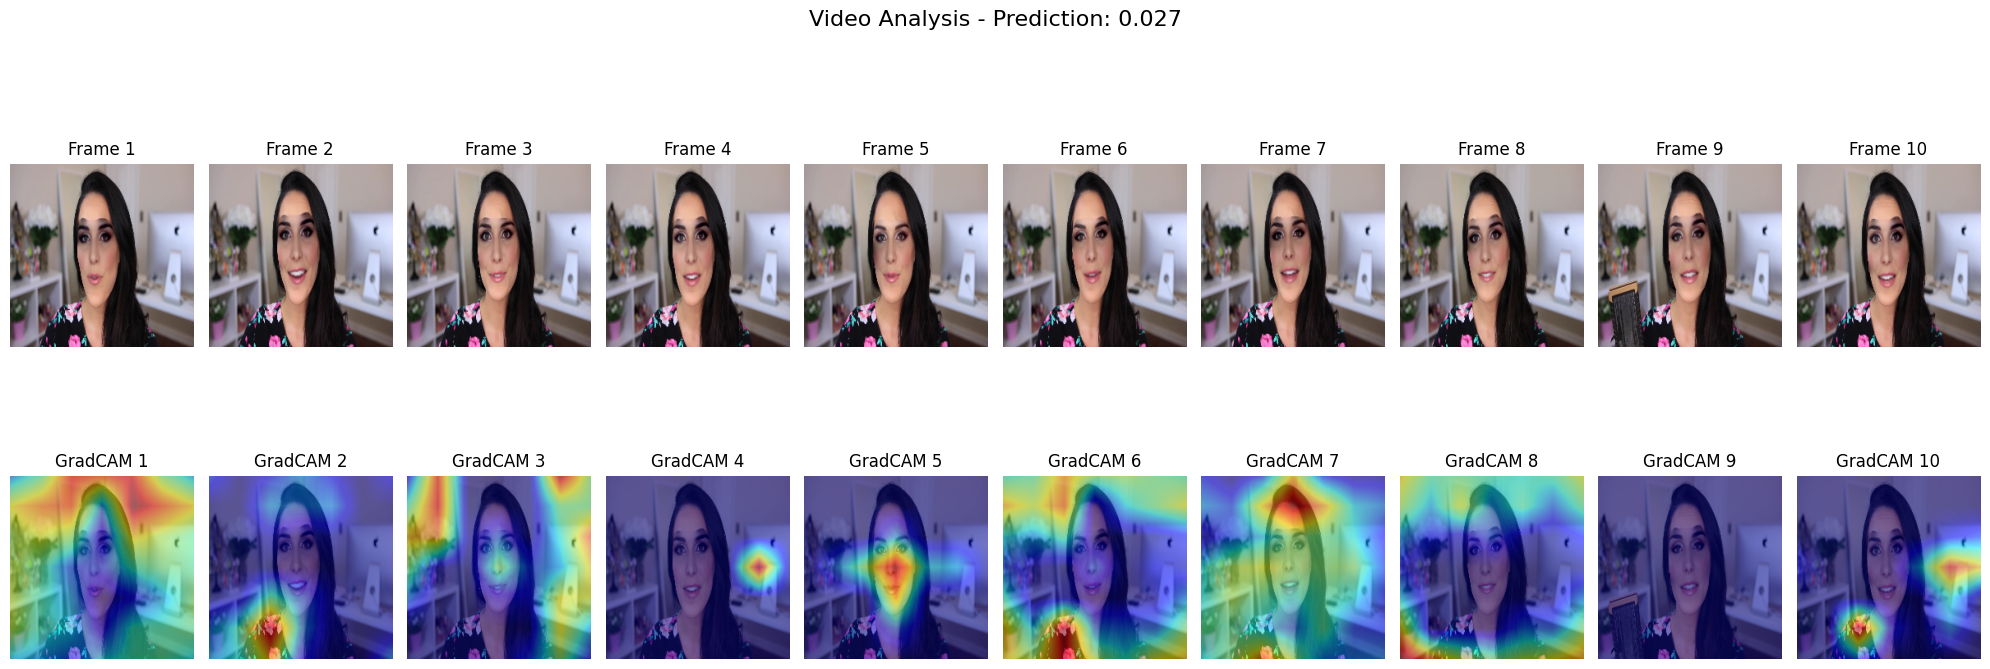

In [ ]:
import os
import tensorflow as tf

# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Define the correct file path
# Use the os.path.join() function for cleaner and safer path handling.
save_path = '/content/drive/My Drive/deepfake_detection/models/'
lstm_model_file = os.path.join(save_path, 'cnn_lstm_model.keras')

# Step 3: Load the model from the verified path
try:
    cnn_lstm_model = tf.keras.models.load_model(lstm_model_file)
    print(f"\nSuccessfully loaded model from: {lstm_model_file}")

    # Now you can proceed with your Grad-CAM implementation
    sample_video = os.path.join(dataset_path, "Deepfakes", "479_706.mp4")
    analyze_video_with_gradcam(cnn_lstm_model, sample_video)

except Exception as e:
    print(f"An error occurred: {e}")